<font size = 25>Flood Extent Mapping in Alice Springs</font.

# Intro
This notebook allows the calculation of Tasselled Cap Wetness (TCW) for a given time series of landsat Scenes.
The TCW is based on the Crist 1985 RF coefficients. Improved coeffieicents for the Australian Context are being developed by Dale Roberts, so the TCW function may need an update soon.


NBART should be used for this analysis, as terrain shadow on southwest facing slopes can show up as 'wetness'.
- would use nbart but having some terrain masking issues today...


This is running it for all sensors - despite being the 1985 paper

-------------------------------------------------------------------- 
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
---------------------------------------------------------------------

# Import some modules

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import datacube
from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data
from datacube.storage.storage import write_dataset_to_netcdf

import gc

import shapely
from shapely.geometry import shape

import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow

import pickle
from skimage import exposure

import warnings


import shapely.geometry
from shapely.geometry import Polygon, Point

import rasterio    

import sys

sys.path.append('/home/547/mb4539/repos/dea-notebooks/Scripts/')
from DEADataHandling import load_nbarx, tasseled_cap
from DEAPlotting import three_band_image

from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# Functions

## function : one_band_image

In [2]:
def one_band_image(ds, layer, time,  continuous_data = True, cmap = 'hsv', figsize = [10,10]):
    def get_cmap(n, name=cmap):
        '''
        Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
        RGB color; the keyword argument name must be a standard mpl colormap name.
        Gratefully pinched from: https://stackoverflow.com/a/25628397/9837690
        '''
        return plt.cm.get_cmap(name, n)
    
    if not continuous_data:
        n = list(np.unique(ds[layer][time].values))
        try:
            n = n.remove(np.nan)
            n = len(n)
        except:
            n = len(n)
        cmap = get_cmap(n, cmap)
        
    img = ds[layer][time]
    try:
        left, bottom, right, top = ds.extent.boundingbox
    except:
        left, right, bottom, top = ds.x.min(), ds.x.max(), ds.y.min(),ds.y.max()
    plt.imshow(img, extent=[left, right, bottom, top], cmap = cmap)
    fig = plt.gcf()
    fig.figsize = figsize
    plt.colorbar()
    ax = plt.gca()
    return ax
    

## function : addDFAsXarrayVariable

In [162]:
def addDFAsXarrayVariable(ds, df, columnname):
    tmp_xarr = xr.Dataset.from_dataframe(res.set_index(['time','y','x']))
    
    return tmp_xarr[columnname]

## function : xarrToDF

In [4]:
def xarrToDF(xarr):
    df = xarr.to_dataframe()
    df = df.reset_index(drop = False)
    
    return df

## function : vectorIntersects

In [5]:
def vectorIntersects(row, polygon):
    if polygon.intersects(row['geometry']):
        return True
    else:
        return False

# Load Datacube Data

In [2]:
dc = datacube.Datacube(app='TCW-EFTFSSC')
sensors = ['ls5','ls7','ls8']
bands = ['blue','green','red','nir','swir1','swir2']
query = {'x' : [180000,188000],
        'y' : [-2568000, -2562000],
        'time' : ['1987-01-01', '2018-04-30'],
        'crs' : 'EPSG:3577'}
data ={}
for sensor in sensors:
    data[sensor] = load_nbarx(dc, sensor, query, product = 'nbart', filter_pq = True)[0]

Failed to resolve driver datacube.plugins.index::s3aio_index


Loading ls5_nbart_albers


Failed to resolve driver datacube.plugins.io.read::s3aio
Failed to resolve driver datacube.plugins.io.read::s3aio_test


Loaded ls5_nbart_albers
Generating mask ls5_pq_albers
Masked ls5_nbart_albers with ls5_pq_albers and filtered terrain
Loading ls7_nbart_albers
Loaded ls7_nbart_albers
Generating mask ls7_pq_albers
Masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


## Pickle if it Required

In [ ]:
with open('ASss_allscenes.pkl', 'wb') as f:
    pickle.dump(data, f)

# Do Stuff With the Data

## Load Data from Pickle

In [151]:
with open('ASss_allscenes.pkl', 'rb') as f:
    data = pickle.load(f)

## Apply TCW and Mask

In [152]:
for key, value in data.items():
    # apply the tasselled cap transformation to the correct sensor
    data[key] = tasseled_cap(sensor_data = data[key], sensor = key, tc_bands = ['wetness'],drop = False)
# squash all the datasets together along the time axis
data = xr.concat(data.values(), dim = 'time')
data

<xarray.Dataset>
Dimensions:  (time: 800, x: 320, y: 240)
Coordinates:
  * y        (y) float64 -2.562e+06 -2.562e+06 -2.562e+06 -2.562e+06 ...
  * x        (x) float64 1.8e+05 1.8e+05 1.801e+05 1.801e+05 1.801e+05 ...
  * time     (time) datetime64[ns] 1987-09-07T00:27:54.500000 ...
Data variables:
    blue     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir2    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    wetness  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 180000.00|\n| 0.00,-25.00,-2562000.00|\n| 0.00, ...

In [153]:
# calculate a mask for the TCW for when > -400 (an empirical threshold identified by Bex)
data['wetness_mask'] = data['wetness'].where(data['wetness'] >=- 400)
# Xarray doesn't seem to easily allow assigning values on a subset selected by boolean masking
# so do the masking in numpy, and assign the resulting mask back to the Xarray
mask = data['wetness_mask'].values
mask[mask > -400] = 1
data['wetness_mask'].values = mask

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


## Convert to dataframe and get ready for sklearn

In [155]:
# convert the wetness mask dataarray to a pandas dataframe for clustering
df = xarrToDF(data['wetness_mask'][729])

# extract just the x and y for clustering (note, dry pixels are NaN)
wet_df = df[df['wetness_mask'] == 1][['y','x']]
# strip the labels off into a plain numpy array for sklearn 
wet_vals = wet_df.values
wet_df.head()

,y,x
632,-2562037.5,187812.5
950,-2562062.5,187762.5
951,-2562062.5,187787.5
952,-2562062.5,187812.5
1255,-2562087.5,187387.5


## Scale, Cluster and Save Results

In [222]:
scaler = preprocessing.StandardScaler().fit(wet_vals)
wet_vals = scaler.transform(wet_vals)
# wet_vals = preprocessing.normalize(wet_vals)

n_clusters = 15

km = MiniBatchKMeans(n_clusters = n_clusters, random_state = 42).fit(wet_vals)
wet_df['clust_num'] = km.labels_
res = pd.merge(df.drop('wetness_mask', axis = 1), wet_df[['clust_num']], how = 'left', left_index = True, right_index = True )
res.head()

,y,x,time,clust_num
0,-2562012.5,180012.5,2015-02-08 01:01:09,NaN
1,-2562012.5,180037.5,2015-02-08 01:01:09,NaN
2,-2562012.5,180062.5,2015-02-08 01:01:09,NaN
3,-2562012.5,180087.5,2015-02-08 01:01:09,NaN
4,-2562012.5,180112.5,2015-02-08 01:01:09,NaN


In [212]:
data['orig_cluster'] = addDFAsXarrayVariable(data, res, 'clust_num')
data

<xarray.Dataset>
Dimensions:       (time: 800, x: 320, y: 240)
Coordinates:
  * time          (time) datetime64[ns] 1987-09-07T00:27:54.500000 ...
  * y             (y) float64 -2.562e+06 -2.562e+06 -2.562e+06 -2.562e+06 ...
  * x             (x) float64 1.8e+05 1.8e+05 1.801e+05 1.801e+05 1.801e+05 ...
Data variables:
    blue          (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    green         (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    red           (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    nir           (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    swir1         (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    swir2         (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    wetness       (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    wetness_mask  (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    orig_cluster  (time, y, x) float64 nan nan 

## View the Initial Results

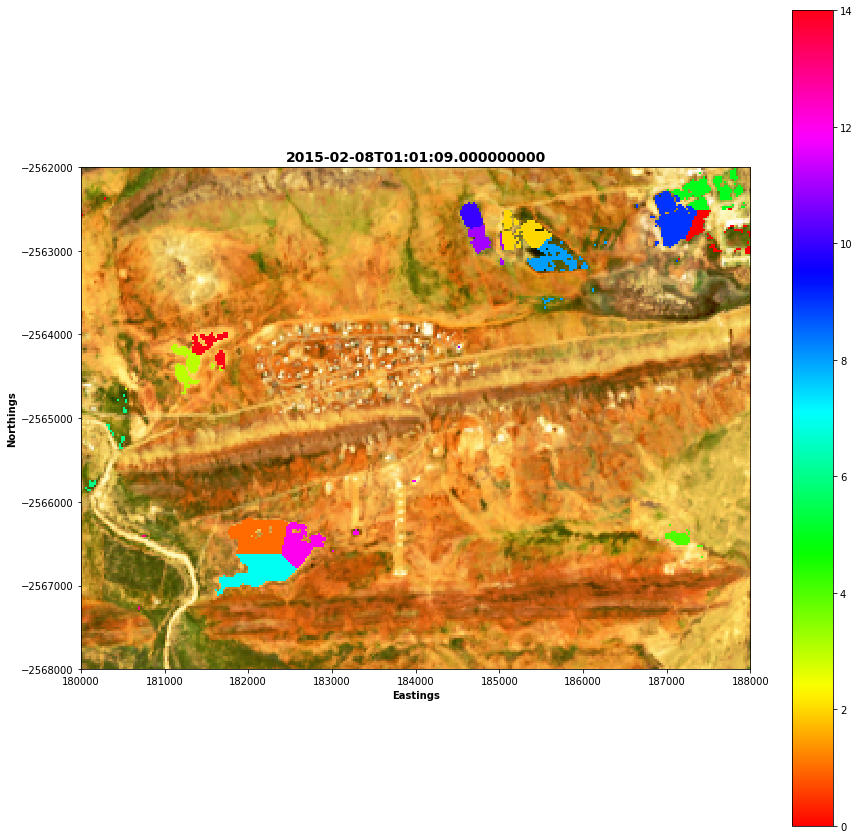

In [213]:
# time slice 729 is the first clear scene after the 2015 flooding rain

three_band_image(data, time = 729, contrast_enhance=True, figsize = [15,15])
one_band_image(data, 'orig_cluster', 729, continuous_data = False, cmap = 'hsv')

In [223]:
res = groupAdjoiningClusters(res)
res.head()

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,y,x,time,clust_num,corrected_clust
0,-2562012.5,180012.5,2015-02-08 01:01:09,NaN,NaN
1,-2562012.5,180037.5,2015-02-08 01:01:09,NaN,NaN
2,-2562012.5,180062.5,2015-02-08 01:01:09,NaN,NaN
3,-2562012.5,180087.5,2015-02-08 01:01:09,NaN,NaN
4,-2562012.5,180112.5,2015-02-08 01:01:09,NaN,NaN


In [215]:
def groupAdjoiningClusters(df):
    # create shapely points for each of the pixels
    wet_df['geometry'] = wet_df.apply(lambda row: Point(row['x'], row['y']), axis = 1)

    # create a dict of bounding box polygons for each of the clusters/classes
    polys ={}
    for cluster in wet_df['clust_num'].unique():
        ss = wet_df[wet_df['clust_num'] == cluster]
        xmin, xmax, ymin, ymax = ss['x'].min(), ss['x'].max(), ss['y'].min(), ss['y'].max()
        poly = Polygon([(xmin, ymax),(xmax, ymax),(xmax, ymin),(xmin, ymin)])
        polys[cluster] = poly
    
    # check if the polys overlap
    # double loop to check each poly against all the others
    # if the polygons intersect the test if if any of the pixels lie in the other polygon
    # if pixels from each cluster lie in both the other polygons, then consider it a match
    # result is a list of cluster numbers that need combining - there are duplicates and
    # disconnected bits that make the logic in the next step very trick
    clusts_to_merge = []
    checked_pairs = []
    for cluster, poly in polys.items():
        for c2, p2 in polys.items():
            if cluster == c2:
                continue
            if [cluster, c2] in checked_pairs or [c2, cluster] in checked_pairs:
                continue
            if poly.intersects(p2):
                # subset wet_df based on c2
                ss = wet_df[wet_df['clust_num'] == c2]
                ss['in_poly'] = ss.apply(lambda row: vectorIntersects(row, poly), axis = 1)
                if ss['in_poly'].any():
                    ss = wet_df[wet_df['clust_num'] == cluster]
                    ss['in_poly'] = ss.apply(lambda row: vectorIntersects(row, p2), axis = 1)
                    if ss['in_poly'].any():
                        clusts_to_merge.append([cluster, c2])
            checked_pairs.append([cluster, c2])

    # make a list of all the clusters that will need to be merged
    nums = []
    for pair in clusts_to_merge:
        if pair[0] not in nums:
            nums.append(pair[0])
        if pair[1] not in nums:
            nums.append(pair[1])
    nums.sort()
    
    # make a dataframe matrix for the matches
    pairs = pd.DataFrame(np.zeros((len(nums), len(nums)), dtype = np.int8), index = nums, columns = nums)
    for clust in clusts_to_merge:
        pairs.loc[clust[0],clust[1]] = 1
        pairs.loc[clust[1],clust[0]] = 1
    
    # this is the tricky logic bit.
    # this works for 3 clusters to be merged, but hasn't yet been tested with a more complicated dataset
    done = set()
    groups = []
    for i, row in pairs.iterrows():
        if i in done:
            continue
        for col in row.index:
            if col in done:
                continue
            elif pairs.loc[i, col] == 0:
                continue
            if pairs.loc[i, col] == 1:
                start_row = i
                start_col = col
                to_add = [start_row, start_col]
                all_cols = list(pairs.loc[start_row][pairs.loc[start_row] == 1].index)
                all_rows = list(pairs[pairs[start_col] == 1].index)
                group = set(to_add) | set(all_cols) | set(all_rows)
                groups.append(group)
                done = done | group
    
    # make a new column to store the corrected clusters
    wet_df['corrected_clust'] = np.nan
    for i, clust in enumerate(groups):
        wet_df.loc[wet_df[wet_df['clust_num'].isin(groups[0])].index, 'corrected_clust'] = n_clusters + i
    wet_df.loc[wet_df[pd.isna(wet_df['corrected_clust'])].index, 'corrected_clust'] = wet_df['clust_num']
    
    df = pd.merge(df, wet_df[['corrected_clust']], how = 'left', left_index = True, right_index = True)
    
    return df

In [198]:
# res = pd.merge(res, wet_df[['corrected_clust']], how = 'left', left_index = True, right_index = True)
res

,x,y,time,corrected_clust_x
0,180012.5,-2562012.5,2015-02-08 01:01:09,NaN
1,180037.5,-2562012.5,2015-02-08 01:01:09,NaN
2,180062.5,-2562012.5,2015-02-08 01:01:09,NaN
3,180087.5,-2562012.5,2015-02-08 01:01:09,NaN
4,180112.5,-2562012.5,2015-02-08 01:01:09,NaN
5,180137.5,-2562012.5,2015-02-08 01:01:09,NaN
6,180162.5,-2562012.5,2015-02-08 01:01:09,NaN
7,180187.5,-2562012.5,2015-02-08 01:01:09,NaN
8,180212.5,-2562012.5,2015-02-08 01:01:09,NaN
9,180237.5,-2562012.5,2015-02-08 01:01:09,NaN


In [205]:
# data['corrected_clust'] = 
newclusts = addDFAsXarrayVariable(data,res,['corrected_clust'])
newclusts

<xarray.Dataset>
Dimensions:          (time: 1, x: 320, y: 240)
Coordinates:
  * time             (time) datetime64[ns] 2015-02-08T01:01:09
  * x                (x) float64 1.8e+05 1.8e+05 1.801e+05 1.801e+05 ...
  * y                (y) float64 -2.568e+06 -2.568e+06 -2.568e+06 -2.568e+06 ...
Data variables:
    corrected_clust  (time, y, x) float64 nan nan nan nan nan nan nan nan ...

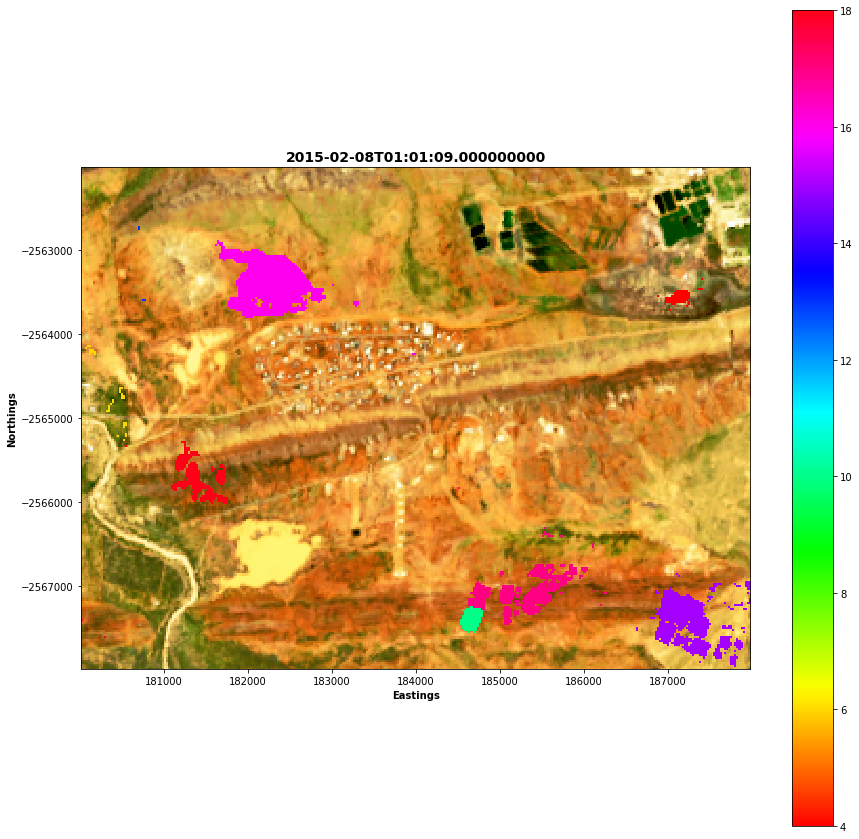

In [209]:
three_band_image(data, time = 729, contrast_enhance=True, figsize = [15,15])
one_band_image(newclusts, 'corrected_clust', 0, continuous_data = False, cmap = 'hsv')

In [135]:
p

# Unused

In [ ]:

# km = DBSCAN(min_samples = 500).fit(wet_vals)
# wet_df['clust_num'] = km.labels_
# wet_df.head()

In [112]:
data['wetness_mask'][729, 190:200, 80:90]

<xarray.DataArray 'wetness_mask' (y: 10, x: 10)>
array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan]])
Coordinates:
  * y        (y) float64 -2.567e+06 -2.567e+06 -2.567e+06 -2.567e+06 ...
  * x        (x) float64 1.82e+05 1.82e+05 1.821e+05 1.821e+05 1.821e+05 ...
    time     datetime64[ns] 2015-02-08T01:01:09

In [ ]:
res_xr = dfToXarray(res, 'clust_num')
res_xr.plot.imshow(figsize=[11,10], cmap = 'viridis')
xmin = 178000
xmax = 188000
ymin = -2570000
ymax = -2560000
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
for clust in wet_df['clust_num'].unique():
    xloc = wet_df[wet_df['clust_num'] == clust]['x'].mean()
    yloc = wet_df[wet_df['clust_num'] == clust]['y'].mean()
    if (xmin <= xloc <= xmax) and (ymin <= yloc <= ymax):
        plt.plot([xloc,yloc],'ro')
        plt.annotate(clust,[xloc, yloc], xytext = [20,0], textcoords = 'offset points', color = 'red')

In [146]:
np.argmax(np.array(counts))

282

In [132]:
# data['wetness_mask'][729].count()
data.time[799]

<xarray.DataArray 'time' ()>
array('2018-04-05T01:00:40.500000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-04-05T01:00:40.500000
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [117]:
data['wetness_mask'].to_dataframe()

wetness_mask
time                    y          x                     
1987-09-07 00:27:54.500 -2562012.5 180012.5           NaN
                                   180037.5           NaN
                                   180062.5           NaN
                                   180087.5           NaN
                                   180112.5           NaN
                                   180137.5           NaN
                                   180162.5           NaN
                                   180187.5           NaN
                                   180212.5           NaN
                                   180237.5           NaN
                                   180262.5           NaN
                                   180287.5           NaN
                                   180312.5           NaN
                                   180337.5           NaN
                                   180362.5           NaN
                                   180387.5           NaN
                                   180412.5           NaN
                                   180437.5           NaN
                                   180462.5           NaN
                                   180487.5           NaN
                                   180512.5           NaN
                                   180537.5           NaN
                                   180562.5           NaN
                                   180587.5           NaN
                                   180612.5           NaN
                                   180637.5           NaN
                                   180662.5           NaN
                                   180687.5           NaN
                                   180712.5           NaN
                                   180737.5           NaN
...                                                   ...
2018-04-05 01:00:40.500 -2567987.5 187262.5           NaN
                                   187287.5           NaN
                                   187312.5           NaN
                                   187337.5           NaN
                                   187362.5           NaN
                                   187387.5           NaN
                                   187412.5           NaN
                                   187437.5           NaN
                                   187462.5           NaN
                                   187487.5           NaN
                                   187512.5           NaN
                                   187537.5           NaN
                                   187562.5           NaN
                                   187587.5           NaN
                                   187612.5           NaN
                                   187637.5           NaN
                                   187662.5           NaN
                                   187687.5           NaN
                                   187712.5           NaN
                                   187737.5           NaN
                                   187762.5           NaN
                                   187787.5           NaN
                                   187812.5           NaN
                                   187837.5           NaN
                                   187862.5           NaN
                                   187887.5           NaN
                                   187912.5           NaN
                                   187937.5           NaN
                                   187962.5           NaN
                                   187987.5           NaN

[61440000 rows x 1 columns]

In [126]:
data['wetness_mask'][729].sum()

<xarray.DataArray 'wetness_mask' ()>
array(2732.)
Coordinates:
    time     datetime64[ns] 2015-02-08T01:01:09

In [ ]:
def xarrayToDF(xarr):
    df = xarr.to_dataframe()
    df = df.reset_index(drop = False)

# Data Loading & Preparation Functions

In [5]:
def getData(study_area, flood_date, days_span, before_flood):
    """
    This is a wrapper for the load_nbart function.
    It allows different study areas to be referenced by name, and also does some case handling for
    deciding which time series to load (either before or after the flood)
    """
    # define the epoch based on the flood date, requested number of days, and before or after the flood
    if before_flood:
        end_of_epoch = datetime.date(int(flood_date[0:4]), int(flood_date[5:7]), int(flood_date[8::]))
        start_of_epoch = end_of_epoch - datetime.timedelta(days = days_span)
    else:
        start_of_epoch = datetime.date(int(flood_date[0:4]), int(flood_date[5:7]), int(flood_date[8::]))
        end_of_epoch = start_of_epoch + datetime.timedelta(days = days_span)
        
    # define the product of interest
    if start_of_epoch > datetime.date(2013,4,1):
        product =  'ls8_nbart_albers' 
    else:
        product = 'ls7_nbart_albers'
               
    # define the bounding box
    if isinstance(study_area, list):
        lon_min, lon_max, lat_min, lat_max = study_area
    if study_area == 'tennantcreek':
        lat_max = -19.18
        lat_min = -20.35
        lon_max = 134.34
        lon_min = 133.41 
    if study_area == 'westerndavenport1':
        lat_max = -20.32
        lat_min = -20.9
        lon_max = 135.02
        lon_min = 133.41   
    if study_area == 'westerndavenport2':
        lat_max = -20.9
        lat_min = -21.5
        lon_max = 135.02
        lon_min = 133.41   
    if study_area == 'westerndavenport3':
        lat_max = -21.5
        lat_min = -22.13
        lon_max = 135.02
        lon_min = 133.41  
    if study_area == 'titree1':
        lat_max = -21.64
        lat_min = -22.4
        lon_max = 134.31
        lon_min = 132.94
    if study_area == 'titree2':
        lat_max = -22.4
        lat_min = -23.13
        lon_max = 134.31
        lon_min = 132.94
    if study_area == 'alicesprings':
        lat_max = -23.42
        lat_min = -24.06
        lon_max = 134.44
        lon_min = 133.51

    # assemble the query 
    query = {'time': (start_of_epoch, end_of_epoch)}    #'dask_chunks': {'time': 5}
    query['long'] = (lon_min, lon_max)
    query['lat'] = (lat_min, lat_max)
    query['crs'] = 'EPSG:4326'

    # Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
    bands_of_interest = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
    
    # actually load the data based on the query assembled
    ds = load_nbart(product,query,bands_of_interest)
    
    return ds

MemoryError: 

## function: maskCloudAndTerrain

In [4]:
def maskCloudAndTerrain(ds, cloud = True, terrain = True):
    """
    Use the pixel quality layer and the -999 for terrain shadowed pixels to np.NaN
    """
    # 16383 is the value for a good (ie clear) pixel
    if cloud:
        ds = ds.where(ds.pixelquality == 16383)
    # -999 occurs when either no data, or when pixel is masked by terrain correction
    if terrain:
        ds = ds.where(ds != -999)
    # return the ds, change to float32 from default float64
    return ds.astype(np.float32)

# Wetness Functions

## function: calc_wetveg_overthresh

In [6]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''
    Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.
    
    Function supplied by Bex Dunn
    '''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

## function: counts_wets

In [7]:
def count_wets(wetness):
    '''
    count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count
    
    Function supplied by Bex Dunn
    '''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

## function: calcWetnessProportion

In [8]:
def calcWetnessProportion(ds):
    """
    This is a wrapper function for all the functions supplied by Bex.
    """
    
    # copy the attribs to preserve them for the end
    attribs = ds.attrs
    # calculate the TCW
    wetness_sensor3_nbart = calc_wetness(ds,'ls8')
    # find when wetness is over the threshold
    water_plus_wetveg_3 = calc_wetveg_overthresh(wetness_sensor3_nbart)
    # count number of time wetness is over threshold
    counts_sensor_3_nbart = count_wets(wetness_sensor3_nbart)
    # calculate proportion of time over threshold
    wet_proportion_allsensors = counts_sensor_3_nbart['threshold count']/counts_sensor_3_nbart['wet count']
    # reassign attribs to the result
    wet_proportion_allsensors.attrs = attribs
    # print a quick and dirty view of the result for simple visual check
    imshow(wet_proportion_allsensors.values)
    plt.colorbar()
    plt.show()
    
    # return the result
    return wet_proportion_allsensors

## function: mosaic

In [12]:
def mosaic(ds, before_flood):
    """
    This function looks forwards or backwards through a given time series taking the the most
    recent valid pixel values (when looking backwards), or the earliest valid pixel values when looking forwards
    """
    # define satellite bands to perform the aggregation for
    sat_bands = ['blue','green','red','nir','swir1','swir2']
    # define the length of the time series
    l = len(ds['red'])
    # create a dict for adding the resulting dataarrays to, for eventual reconstruction as a dataset
    allres = {}
    
    for band in sat_bands:
        if not before_flood: # ie if after flood
            # start off at the first scene after the flood
            res = ds[band][0].drop(labels='time')
            # loop through the rest of the scenes, if the first scene has invalid pixels, the pixel value
            # becomes the value of the second one in the combine first 
            for i in range(1, l):
                res = res.combine_first(ds[band][i].drop(labels='time'))
            # save result into the dict
            allres[band] = res
        else:
            # same as above, but this time starting at the most recent scene and working back
            res = ds[band][l-1].drop(labels='time')
            for i in range(l - 1, 0, -1):
                res = res.combine_first(ds[band][i-1].drop(labels='time'))
            allres[band] = res
            
    # combine the results into a new dataset. Force the datatype to float32 just incase it has changed
    return xr.Dataset(allres).astype(np.float32)      

 # Running it All

In [25]:
as_ap_rain = pd.read_csv('../KeyData/IDCJAC0009_015590_1800_Data.csv')
as_ap_rain = as_ap_rain[as_ap_rain['Year'] >= 1980]
as_ap_rain.head()

FileNotFoundError: File b'../KeyData/IDCJAC0009_015590_1800_Data.csv' does not exist